# Introduction

## Final Project Submission

***
- Student Name: Adam Marianacci
- Student Pace: Flex
- Scheduled project review date/time: TBD
- Instructor Name: Mark Barbour

# Business Understanding

It is my job to help SXSW detect positive sentiment from tweets about their event so that they can continue to give people what they want and make improvements for the future. 

# Data Understanding

This dataset comes from 'CrowdFlower' via data.world. The initial dataframe contained roughly 9,000 tweets and information about the sentiment of the tweet as well as what brand or product the tweet was directed at. Some limitations of the dataset included missing values as well as a class imbalance in the sentiment of the tweets. Over 50% of the tweets showed no emotion, about 33% showed a positive emotion, and only around 6% showed a negative emotion. Due to this imbalance I combined some of the 'no emotion' tweets with the 'negative emotion' tweets to create a 'Not Positive' class to match the 'Positive' class. There was a lot of missing data from the emotion about the brands so I was unable to conduct analysis in this area. This dataset was suitable for the project because it allowed me to build a sentiment detection model from the text in the tweets against the target 'sentiment' of what was positive and what was not.


Dataset: [Brands and Product Emotions](https://data.world/crowdflower/brands-and-product-emotions)

# Data Preperation

In [1]:
# Importing the necessary libraries

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import numpy as np
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import defaultdict
from collections import Counter
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the data, and looking at the shape of the df

corpus = pd.read_csv('data/twitter_sentiment.csv', encoding='latin1')
corpus.shape

(9093, 3)

In [3]:
# previewing the dataframe
corpus.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
# Taking a look at the datatypes and checking for missing values
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
# Dropping 'the emotion_in_tweet_is_directed_at' column, bc of missing values and not needed for our problem.
corpus.drop('emotion_in_tweet_is_directed_at', axis=1, inplace=True)

In [6]:
# renaming the 'is_there_an_emotion...' column to 'sentiment'
corpus.rename(columns={
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

In [7]:
# Inspecting the values in 'sentiment'. We have an imbalance in occurences. 
corpus['sentiment'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [8]:
# Dropping 'I can't tell' category because it is not useful and a relatively low amount.
corpus.drop(corpus[corpus['sentiment'] == "I can't tell"].index, inplace=True)

In [9]:
# Creating a mask to identify rows with "No emotion toward brand or product"
no_emotion_mask = corpus['sentiment'] == "No emotion toward brand or product"

# Locating the rows with the mask and redistribute 2,408 occurrences
no_emotion_indices = corpus[no_emotion_mask].sample(n=2408, random_state=42).index
corpus.loc[no_emotion_indices, 'sentiment'] = "Negative emotion"

# Verifying the changes
print(corpus['sentiment'].value_counts())

No emotion toward brand or product    2981
Positive emotion                      2978
Negative emotion                      2978
Name: sentiment, dtype: int64


In [10]:
# Create a mask to identify rows with "No emotion toward brand or product"
no_emotion_mask = corpus['sentiment'] == "No emotion toward brand or product"

# Drop the rows with this mask
corpus.drop(corpus[no_emotion_mask].index, inplace=True)

# Verify the changes
print(corpus['sentiment'].value_counts())

Positive emotion    2978
Negative emotion    2978
Name: sentiment, dtype: int64


In [11]:
# Define the mapping of old values to new values
mapping = {'Positive emotion': 'Positive', 'Negative emotion': 'Not Positive'}

# Replace the categories in the 'sentiment' column
corpus['sentiment'] = corpus['sentiment'].replace(mapping)

# Verify the changes
print(corpus['sentiment'].value_counts())

Not Positive    2978
Positive        2978
Name: sentiment, dtype: int64


In [12]:
# Assigning 'Positive' sentiment to 1 and 'Not Positive' to 0
corpus['sentiment'] = corpus['sentiment'].replace(
    {'Positive': 1, 'Not Positive': 0})

In cells 9-12 we have set this up to be a binary classification problem. We have combined values from "Negative emotion" with values from "No emotion toward brand or product". We did this because we had a class imbalance. We sampled 2,408 occurences from "No emotion toward brand or product" and combined them in the "Negative emotion" category to create a new category called "Not Positive". There were a lot more occurences of "Positive emotion" compared to "Negative emotion". By combining the categories we have now have a balance between 'Positive' and 'Not Positive' occurences. We have assigned sentiment values 'Positive' to 1 and 'Not Positive' to 0.

In [13]:
# Inspecting the DF once again to make sure everything looks correct after all the changes we made.
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5956 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5956 non-null   object
 1   sentiment   5956 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 139.6+ KB


In [14]:
# The number of entries are equal in 'tweet_text' and 'sentiment'
corpus.describe()

,sentiment
count,5956.000000
mean,0.500000
std,0.500042
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [15]:
corpus.head()

,tweet_text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1


Inspecting common words that have low semantic value that could potentially be added to 'stopwords'

In [16]:
# Finding the top 10 most used words in the tweets
all_words = ' '.join(corpus['tweet_text']).split()

# Calculate the frequency distribution of words
word_freq = FreqDist(all_words)

# Get the top 10 most frequent words
top_20_words = word_freq.most_common(20)

# Print the top 10 most frequent words
for word, freq in top_20_words:
    print(f'{word}: {freq}')

@mention: 4211
the: 2671
#sxsw: 2602
{link}: 2579
#SXSW: 2384
to: 2328
RT: 1851
at: 1848
for: 1594
a: 1484
iPad: 1206
in: 1181
of: 1151
is: 1141
and: 1022
Google: 994
Apple: 991
on: 817
I: 724
store: 618


In [17]:
# Defining X and y
X = corpus.tweet_text
y = corpus.sentiment

Below is our holdout test set.

In [18]:
# Setting up train,test,split, 20% on testing 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2)

Preprocess the training set.

In [19]:
# Bring in stopwords, words with low semantic value

sw = stopwords.words('english')
# add additional words to the stopwords list
additional_stopwords = ['sxsw', 'apple', 'google', 'austin', 'ipad', 
                        'iphone', 'mention', 'android', 'rt', 'link',
                       'app', 'quot', 'store', 'aaron', 'abc', 'aapl',
                       'ab']
sw.extend(additional_stopwords)

In [20]:
# Translating nltk pos_tags to wordnet pos_tags to ensure compatability between libraries
# Preparing for lemmatization
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [21]:
# removing punctuation, lower casing, removing numbers, lemmatizing the tweets
def tweet_preparer(tweet, stop_words=sw, ):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [22]:
# Select a sample tweet from the corpus DataFrame
sample_tweet = corpus['tweet_text'].iloc[522]  #'tweet_text' is the column containing the tweets
print(sample_tweet)
# Apply tweet_preparer function to preprocess the sample tweet
preprocessed_tweet = tweet_preparer(sample_tweet)
print(preprocessed_tweet)

@mention  Its bigger than an iphone and smaller than a PC, so good for big events like #SXSW and meeting day? {link}
big small pc good big event like meeting day


In [23]:
# Creating the variable 'token_tweets' to preprocess all the tweets in the corpus using a list comprehension.
token_tweets = [tweet_preparer(tweet, sw) for tweet in X_train]

In [24]:
# Secondary train-test split to build our baseline model
X_train2, X_val, y_train2, y_val = train_test_split(token_tweets, y_train, test_size=0.2, random_state=42)

In [25]:
cv = CountVectorizer()

X_train2_vec = cv.fit_transform(X_train2)
X_train2_vec = pd.DataFrame.sparse.from_spmatrix(X_train2_vec)
X_train2_vec.columns = sorted(cv.vocabulary_)
X_train2_vec.set_index(y_train2.index, inplace=True)

In [26]:
# Get the shape of the 'X_train2_vec' sparse matrix
num_rows, num_columns = X_train2_vec.shape

print("Number of rows in 'X_train2_vec':", num_rows)
print("Number of columns in 'X_train2_vec':", num_columns)


Number of rows in 'X_train2_vec': 3811
Number of columns in 'X_train2_vec': 5148


In [27]:
X_train2_vec

,ability,able,abound,abroad,absolutely,absolutley,abt,abuzz,acc,access,...,zip,zite,zlf,zms,zomb,zombie,zomg,zone,zoom,zynga
7286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4053,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
X_train2_vec

,ability,able,abound,abroad,absolutely,absolutley,abt,abuzz,acc,access,...,zip,zite,zlf,zms,zomb,zombie,zomg,zone,zoom,zynga
7286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4053,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# We then transform the validation set. Do not refit the vectorizer

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)


In [30]:
X_val_vec

,ability,able,abound,abroad,absolutely,absolutley,abt,abuzz,acc,access,...,zip,zite,zlf,zms,zomb,zombie,zomg,zone,zoom,zynga
3342,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6817,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling

In [31]:
# Fitting the Multinomial Naive Bayes Classifier on our training data
mnb = MultinomialNB()

mnb.fit(X_train2_vec, y_train2)

MultinomialNB()

In [32]:
# Evaluating our training data
y_train_pred = mnb.predict(X_train2_vec)
accuracy_score(y_train2, y_train_pred)

0.8509577538703752

In [33]:
# Generating model predictions and getting an accuracy score for our Testing Data
y_pred = mnb.predict(X_val_vec)
accuracy_score(y_val, y_pred)

0.646379853095488

In [34]:
# calculating a precision score
precision_score(y_val, y_pred)

0.6408839779005525

We got an 85% accuracy score on our training data and roughly a 65% accuracy score on our testing data. We had a similar score of 64% on precision. Our model did do significantly better on the training data most likely due to overfitting from noise in the training data (too many irrelevant words).

In [35]:
# Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0],              # alpha parameter for MultinomialNB
}

# Initialize MultinomialNB classifier
mnb = MultinomialNB()

# Perform GridSearchCV with accuracy as the scoring metric with 5 folds
grid_search = GridSearchCV(mnb, param_grid, cv=5, scoring='accuracy')

# Training the GridSearchCV on the training data
grid_search.fit(X_train2_vec, y_train2)

# Geting the best accuracy score and hyperparameters
best_accuracy = grid_search.best_score_
best_params = grid_search.best_params_

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)

Best Accuracy: 0.6473373167803566
Best Parameters: {'alpha': 0.5}


The GridSearch mnb model led to an ever so slight improvement, but roughly the same.

In [36]:
# Setting up a confusion matrix on our testing data
cm = confusion_matrix(y_val, y_pred)


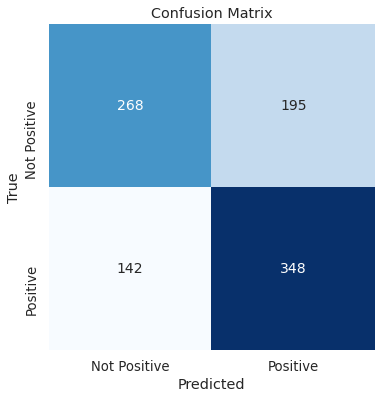

In [37]:
# Set up a figure and axis
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            annot_kws={"size": 14}, square=True,
            xticklabels=['Not Positive', 'Positive'],
            yticklabels=['Not Positive', 'Positive'])

# Labeling and viewing the cm
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Fitting a tfidf model on training data to make predictions with words that appear in 5%-95% of tweets
tfidf = TfidfVectorizer(min_df=0.05, max_df=0.95)
X_train2_vec = tfidf.fit_transform(X_train2)
X_val_vec = tfidf.transform(X_val)
mnb2 = MultinomialNB()
mnb2.fit(X_train2_vec, y_train2)
y_pred2 = mnb2.predict(X_val_vec)

accuracy_score(y_val, y_pred2)

0.4963273871983211

In [39]:
precision_score(y_val, y_pred2)

0.5201612903225806

The tfidf mnb model with min, max hyperparameters led to a worse accuracy score of almost 50%, and had a worse precision score as well at 52%.

In [40]:
# Fitting a Random Forest Classifier on training data, and making predictions on validation data
rf = RandomForestClassifier(n_estimators=1000, max_features=5, max_depth=5)
rf.fit(X_train2_vec, y_train2)
y_pred3 = rf.predict(X_val_vec)
precision_score(y_val, y_pred3)

0.5210396039603961

In [41]:
accuracy_score(y_val, y_pred3)

0.521511017838405

The random forest model with hyperparameters did not perform as well as the mnb model. This model had an accuracy score of 52%

In [42]:
# Get feature importances from the trained Random Forest classifier
feature_importances = rf.feature_importances_

# Get the indices of the top 10 most important features
top_feature_indices = feature_importances.argsort()[-10:][::-1]

# Get the vocabulary from the CountVectorizer
vocab = cv.get_feature_names_out()

# Print the top 10 most important words
print("Top 10 most important words:")
for index in top_feature_indices:
    word = vocab[index]
    importance = feature_importances[index]
    print(f"{word}: {importance:.6f}")

Top 10 most important words:
acc: 0.249670
abound: 0.190295
able: 0.141614
ability: 0.136165
absolutley: 0.092315
abroad: 0.053316
absolutely: 0.047517
access: 0.041522
abuzz: 0.036644
abt: 0.010943


# Evaluation

Our best performing model was our Multinomial Bayes model that used a GridSearch with hyperparameters, the alpha was set to 1. This is an example of Laplace smoothing which avoids the problem of zero probabilities of unseen words in the training data. The model was trained on data using a count vectorizer of all the words in the corpus after preprocessing. It had an accuracy score of about 65% which is not great in determining whether tweets had positive sentiment or not. It also had a precision score that was roughly the same. We looked at accuracy as the best metric because in terms of minimizing false/negatives and false/positives, one was not more important than the other. Therefore precision and recall didn't matter as much as accuracy. It was a better metric because we had a balance in our classes. Our confusion matrix confirmed this by showing we had 616 True Predictions out of 953 possible in our sample.

# Conclusion

## Limitations

Some limitations of the data was that there was a pretty heavy class imbalance in sentiment. Over half of the data (in this case tweets) showed to have no emotion. With only 33% showing positive sentiment and only around 6% showing negative sentiment. This forced us to combine no emotion tweets and negative tweets to create a 'Not Positive' category. This contributed to our models not being very accurrate. There were also a lot of missing values (nearly 2/3) of the data was missing from the 'emotion_in_tweet_is_directed_at' column so I was not able to analyze sentiment regarding certain products. After cleaning the data we were only able to work with around 6,000 entries which is fairly low when it comes to building predictive models. 

## Recommendations

## Next Steps

We need to gather more data on negative sentiment as well as positive sentiment. Negative sentiment is just as useful and in some cases more useful information to have to know what to avoid and how to make improvements. We need to gather 10x more data from other social media platforms as well, not just twitter. Gathering information on specific areas of the conference (whether it be in film, music, education or brands in tech) will help SXSW become an even better more well rounded event rather than just looking at general sentiment towards the event. 